In [ ]:
"""
Viewer for framebot_v2 model - update files to your locations
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import tensorflow as tf
from keras.models import load_model

import random as rand

import sys

In [ ]:
plt.rcParams['figure.figsize'] = [10,10]

In [ ]:
test_x = np.load('/content/drive/MyDrive/framebot_V2/data/test_input.npy', allow_pickle=True)
test_y = np.load('/content/drive/MyDrive/framebot_V2/data/test_label.npy', allow_pickle=True)

In [ ]:
# model location
save_model_path = "/content/drive/MyDrive/framebot_V2/model/framebot_v2.0_3d_Unet_1.2.h5"

In [ ]:
model = load_model(save_model_path, compile=False)

In [ ]:
class GenBuilding:
    """
    Class to create a 3d representation of a building training data using channels for
    different class elements. Building area is limited to 32x32x32.
    parameters:
    bldg_type:
        0 - square bays - > shear wall building
        1 - rectangular bays -> braced building
        2 - rectangular bays -> moment frame
 
    element classes:
    0 - empty space
    1 - element location

    output: 3-d arrays
    1 - architectural model -> single 3-d array
    2 - structural model -> 3-d array with multiple channels
        channels: floors, cols, beams, walls, braces, moments, background
    """

    def __init__(self):
        self.dim = 32
        self.bldg_type = 0
        self.bay_dim = 8
        self.width = 8
        self.length = 8
        self.floor_ht = 8
        self.num_floors = 4

        self.floors = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.walls = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.ext = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.cols = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.braces = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.moments = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.beams = np.zeros((self.dim, self.dim, self.dim), dtype=int)

        # convenience variable
        self.cut_array = np.zeros((self.dim, self.dim, self.dim), dtype=int)

        # data for model
        self.struct_layers = 7
        self.arch_input = np.zeros((self.dim, self.dim, self.dim), dtype=int)
        self.struct_label = np.zeros((self.struct_layers, self.dim, self.dim, self.dim), dtype=int)
      
        self.x_bays = 4 # width - left to right
        self.y_bays = 4 # length - front to back
        self.major_axis = 0  # 0: x-axis, 1: y-axis

        # cut dimensions - in bays
        self.corner_x_left_back = 0
        self.corner_x_left_front = 0
        self.corner_x_right_back = 0
        self.corner_x_right_front = 0
        self.corner_y_left_back = 0
        self.corner_y_left_front = 0
        self.corner_y_right_back = 0
        self.corner_y_right_front = 0
        self.center_right = 0
        self.center_back = 0
        self.center_left = 0
        self.center_front = 0


    def gen_building_dims(self):
        """
        Create building via random dimensions
        - creates a random building primary dimensions
        - overwrites old dimensions if called
        """
        # general dimensions
        if self.bldg_type == 0:
            self.x_bays = rand.randint(2, 4)
            self.y_bays = rand.randint(2, 4)

        # choose major axis: only for bldg_types > 0
        if self.bldg_type == 1:
            self.major_axis = rand.choice([0, 1])
            if self.major_axis == 0:
                self.x_bays = 4
                self.y_bays = rand.choice([2, 4])
            else:
                self.x_bays = rand.choice([2, 4])
                self.y_bays = 4

        self.num_floors = rand.randint(1, 4)

        # set dimensions
        self.bay_dim = rand.choice([6, 8])
        self.width = self.bay_dim
        self.length = self.bay_dim
        self.floor_ht = self.bay_dim


    def cut_left_front(self, max_cut):
        self.corner_x_left_front = rand.choice([1, max_cut])
        self.corner_y_left_front = rand.choice([1, max_cut])
        x_cut = self.corner_x_left_front * self.width - 1
        y_cut = self.corner_y_left_front * self.length - 1
        self.cut_array[:x_cut, :y_cut, :] = 1


    def cut_left_back(self, max_cut):
        self.corner_x_left_back = rand.choice([1, max_cut])
        self.corner_y_left_back = rand.choice([1, max_cut])
        x_cut = self.corner_x_left_back * self.width - 1
        y_cut = (self.y_bays - self.corner_y_left_back) * self.length
        self.cut_array[:x_cut, y_cut:, :] = 1
    

    def cut_right_front(self, max_cut):
        self.corner_x_right_front = rand.choice([1, max_cut])
        self.corner_y_right_front = rand.choice([1, max_cut])
        x_cut = (self.x_bays - self.corner_x_right_front) * self.width
        y_cut = self.corner_y_right_front * self.length - 1
        self.cut_array[x_cut: , :y_cut, :] = 1


    def cut_right_back(self, max_cut):
        self.corner_x_right_back = rand.choice([1, max_cut])
        self.corner_y_right_back = rand.choice([1, max_cut])
        x_cut = (self.x_bays - self.corner_x_right_back) * self.width
        y_cut = (self.y_bays - self.corner_y_right_back) * self.length
        self.cut_array[x_cut:, y_cut:, :] = 1


    def cut_center_left(self, max_cut):
        self.center_left = rand.choice([1, max_cut])
        x_cut = self.center_left * self.width - 1
        y_cut_start = self.length
        y_cut_end = 3 * self.length - 1
        self.cut_array[:x_cut, y_cut_start:y_cut_end, :] = 1


    def cut_center_back(self, max_cut):
        self.center_back = rand.choice([1, max_cut])
        x_cut_start = self.width
        x_cut_end = 3 * self.width
        y_cut = (self.y_bays - self.center_back) * self.length - 1
        self.cut_array[x_cut_start:x_cut_end, y_cut:, :] = 1


    def cut_center_right(self, max_cut):
        self.center_right = rand.choice([1, max_cut])
        x_cut = self.dim - (self.center_right * self.width)
        y_cut_start = self.length
        y_cut_end = 3 * self.length - 1
        self.cut_array[x_cut:, y_cut_start:y_cut_end, :] = 1


    def cut_center_front(self, max_cut):
        self.center_front = rand.choice([1, max_cut])
        x_cut_start = self.width
        x_cut_end = 3 * self.width - 1
        y_cut = self.center_front * self.length - 1
        self.cut_array[x_cut_start:x_cut_end, :y_cut, :] = 1
    

    def cut_L_bldg(self, max_cut):
        # print("L bldg")
        _choice =  rand.randint(0, 3)
        if _choice == 0:
            self.cut_left_front(max_cut)
        elif _choice == 1:
            self.cut_left_back(max_cut)
        elif _choice == 2:
            self.cut_right_front(max_cut)
        elif _choice == 3:
            self.cut_right_back(max_cut)
        else:
            raise Exception("_choice out of range")


    def cut_T_bldg(self, max_cut):
        # print("T bldg")
        _choice =  rand.randint(0, 3)
        if _choice == 0:
            self.cut_left_front(max_cut)
            self.cut_left_back(max_cut)
        elif _choice == 1:
            self.cut_left_back(max_cut)
            self.cut_right_back(max_cut)
        elif _choice == 2:
            self.cut_right_front(max_cut)
            self.cut_right_back(max_cut)
        elif _choice == 3:
            self.cut_left_front(max_cut)
            self.cut_right_front(max_cut)
        else:
            raise Exception("_choice out of range")
    

    def cut_C_bldg(self, max_cut):
        # print("C bldg")
        _choice =  rand.randint(0, 3)
        if _choice == 0:
            self.major_axis = 1
            self.cut_center_left(max_cut)  
        elif _choice == 1:
            self.major_axis = 0
            self.cut_center_back(max_cut)
        elif _choice == 2:
            self.major_axis = 1
            self.cut_center_right(max_cut)
        elif _choice == 3:
            self.major_axis = 0
            self.cut_center_front(max_cut)
        else:
            raise Exception("_choice out of range")


    def cut_H_bldg(self, max_cut):
        # print("H bldg")
        _choice = rand.choice([0, 1])
        if _choice == 0:
            self.cut_center_left(max_cut)
            self.cut_center_right(max_cut)
        elif _choice == 1:
            self.cut_center_front(max_cut)
            self.cut_center_back(max_cut)
        else:
            raise Exception("_choice out of range")

    
    def cut_Plus_bldg(self, max_cut):
        # print("+ bldg")
        self.cut_left_front(max_cut)
        self.cut_left_back(max_cut)
        self.cut_right_front(max_cut)
        self.cut_right_back(max_cut)

    
    def gen_bldg_shape(self):
        if self.bldg_type == 0:
            if self.x_bays == 4 and self.y_bays == 4:
                _choice = rand.randint(0, 5)
                if _choice == 0:
                    _max_cut = 2
                    self.cut_L_bldg(_max_cut)
                elif _choice == 1:
                    _max_cut = 2
                    self.cut_C_bldg(_max_cut)
                elif _choice == 2:
                    _max_cut = 1
                    self.cut_H_bldg(_max_cut)
                elif _choice == 3:
                    _max_cut = 1
                    self.cut_Plus_bldg(_max_cut)
                elif _choice == 4:
                    _max_cut = 1
                    self.cut_T_bldg(_max_cut)
                elif _choice == 5:
                    pass
                    # building is a square
                else:
                    raise Exception("_choice out of range")
            elif self.x_bays >= 3 and self.y_bays >= 3:
                _choice = rand.randint(0, 2)
                if _choice == 0:
                    _max_cut = 2
                    self.cut_L_bldg(_max_cut)
                elif _choice == 1:
                    _max_cut = 1
                    self.cut_T_bldg(_max_cut)
                elif _choice == 2:
                    pass
                    # building is a square
                else:
                    raise Exception("_choice out of range")
        # limit steel frames to simpler shapes
        else:
            if self.x_bays == 4 and self.y_bays == 4:
                _choice = rand.randint(0, 3)
                if _choice == 0:
                    _max_cut = 2
                    self.cut_L_bldg(_max_cut)
                elif _choice == 1:
                    _max_cut = 1
                    self.cut_Plus_bldg(_max_cut)
                elif _choice == 2:
                    _max_cut = 1
                    self.cut_T_bldg(_max_cut)
                elif _choice == 3:
                    pass
                    # building is a square
                else:
                    raise Exception("_choice out of range")
            elif self.x_bays >= 3 and self.y_bays >= 3:
                _choice = rand.randint(0, 2)
                if _choice == 0:
                    _max_cut = 2
                    self.cut_L_bldg(_max_cut)
                elif _choice == 1:
                    _max_cut = 1
                    self.cut_T_bldg(_max_cut)
                elif _choice == 2:
                    pass
                    # building is a square
                else:
                    raise Exception("_choice out of range")


    def gen_floors(self):
        """ Generates floor plates """
        floor_x = self.x_bays * self.width
        floor_y = self.y_bays * self.length
        for i in range(self.num_floors):
            level = 0
            if i == 0:
                level = self.floor_ht - 1  # adjust to zero cell for array
            if i > 0:
                level = (i + 1) * self.floor_ht - 1
            self.floors[:floor_x, :floor_y, level] = 1
        # remove building corners or indents
        # self.floors = np.where(self.cut_array==1, 0, self.floors)


    def gen_cols(self):
        """ Generate columns """
        num_cols_x = self.x_bays + 1
        num_cols_y = self.y_bays + 1
        col_bot = 0
        col_top = 0
        for i in range(self.num_floors):
            if i == 0:
                col_top = self.floor_ht
            else:
                col_bot = col_top
                col_top = col_bot + self.floor_ht
            for j in range(num_cols_x):
                if j == 0:
                    x_coord = 0
                else:
                    x_coord = j * self.width - 1
                for k in range(num_cols_y):
                    if k == 0:
                        y_coord = 0
                    else:
                        y_coord = k * self.length - 1
            
                    self.cols[x_coord, y_coord, col_bot:col_top] = 1

        
      
    def gen_ext(self, dir, coord, bay):
        """ Generate exterior wall framing for arch model with openings
        dir:
        0 - x axis wall
        1 - y axis wall

        coord: where wall starts (left for x, nearest for y)
        bay: bay to generate wall in
        """
        _width = 0
        if dir == 0:
            _width = self.width
        elif dir == 1:
            _width = self.length
        else:
            raise Exception("dir is out of range")

        # exterior with openings
        for i in range(self.num_floors):
            # start_pt = coord + i
            wall_bot = 0
            wall_start = 0

            if i == 0:
                wall_top = self.floor_ht - 1

            if i > 0:
                wall_bot = wall_top + 1
                wall_top = wall_bot + self.floor_ht - 1
            
            if bay > 0:
                wall_start = bay * _width - 1

            wall_end = wall_start + _width

            # openings hard coded for 6 and 8 widths
            if _width == 8:
                opening_start = wall_start + 2
            elif _width == 6:
                opening_start = wall_start + 1

            if self.floor_ht == 8:
                opening_bot = wall_bot + 2
            elif self.floor_ht == 6:
                opening_bot = wall_bot + 1

            opening_end = opening_start + 4
            opening_top = opening_bot + 4

            if dir == 0:
                self.ext[wall_start:wall_end, coord, wall_bot:wall_top] = 1
                self.ext[opening_start:opening_end, coord, opening_bot:opening_top] = 0
            elif dir == 1:
                self.ext[coord, wall_start:wall_end, wall_bot:wall_top] = 1
                self.ext[coord, opening_start:opening_end, opening_bot:opening_top] = 0
            else:
                raise Exception("dir out of range")

    
    def gen_wall(self, dir, coord, bay):
        """ Generate structural wall framing for arch and struct model
        dir:
            0 - x axis wall
            1 - y axis wall

        coord: array / grid number where wall starts (left for x, nearest for y)
        bays: bays to generate from low to high point coordinates
        """
        _width = 0
        if dir == 0:
            _width = self.width
        elif dir == 1:
            _width = self.length
        else:
            raise Exception("dir is out of range")

        for i in range(self.num_floors):
            wall_bot = 0
            wall_start = 0

            if i == 0:
                wall_top = self.floor_ht - 1

            if i > 0:
                wall_bot = i * self.floor_ht - 1

            wall_top = (i + 1) * self.floor_ht

            if bay == 0:
                wall_end = _width
            else:
                wall_start = bay * _width - 1
                wall_end = wall_start + _width + 1

            if dir == 0:
                self.walls[wall_start:wall_end, coord, wall_bot:wall_top] = 1
            elif dir == 1:
                self.walls[coord, wall_start:wall_end, wall_bot:wall_top] = 1
            else:
                raise Exception("dir out of range")


    def gen_brace(self, dir, coord, bay):
        """ Generate braces for struct model
        dir:
            0 - x axis wall
            1 - y axis wall

        coord: array / grid number where wall starts (left for x, nearest for y)
        bays: bays to generate from low to high point coordinates
        """
        _width = 0
        if dir == 0:
            _width = self.width
        elif dir == 1:
            _width = self.length
        else:
            raise Exception("dir is out of range")

        for i in range(self.num_floors):
            brc_bot = 0
            brc_start = 0
            if i == 0:
                brc_top = self.floor_ht - 1
            if i > 0:
                brc_bot = brc_top + 1
                brc_top = brc_bot + self.floor_ht - 1
            if bay > 0:
                brc_start = bay * _width - 1
            brc_end = brc_start + self.floor_ht - 1

            j = 0
            while j < _width:
                if j > 0 and j < (_width-1):   # <<=== may be an error in waiting
                    _x = brc_start + j
                    _z = brc_bot + j
                    #### Bays are equal - update some day to deal
                    #### with different height and widths -> V2
                    if dir==0:
                        self.braces[_x, coord, _z ] = 1
                    elif dir==1:
                        self.braces[coord, _x, _z] = 1
                    else:
                        raise Exception("out of range")
                j += 1


    def gen_beams(self):
        """ Generate beams 
        """
        num_cols_x = self.x_bays + 1
        num_cols_y = self.y_bays + 1
        for i in range(self.num_floors):
            y_coord = 0
            level = 0
            if i == 0:
                level = self.floor_ht - 1
            elif i > 0:
                level = (i + 1) * self.floor_ht - 1
            
            for j in range(num_cols_x):
                if j == 0:
                    x_coord = 0
                else:
                    x_coord = j * self.width - 1
                y_coord = self.y_bays * self.length - 1
                self.beams[x_coord, :y_coord, level] = 1

            for k in range(num_cols_y):
                if k == 0:
                    y_coord = 0
                else:
                    y_coord = k * self.length - 1
                x_coord = self.x_bays * self.width - 1
                self.beams[:x_coord, y_coord, level] = 1 
       

    def gen_moment_frame(self, dir, coord, bay):
        """ Generate a moment frame for the struct model
        dir:
            0 - x axis 
            1 - y axis 

        coord: array / grid number where frame starts (left for x, nearest for y)
        bays: bays to generate from low to high point coordinates
        """
        _width = 0
        if dir == 0:
            _width = self.width
        elif dir == 1:
            _width = self.length
        else:
            raise Exception("dir is out of range")

        for i in range(self.num_floors):
            frame_bot = 0
            frame_start = 0
            frame_end = _width - 1
            level = self.floor_ht - 1
            if bay > 0:
                frame_start = bay * _width - 1
                frame_end = frame_start + _width
            if i > 0:
                level = (i + 1) * self.floor_ht - 1
            if dir == 0:
                # beam
                self.moments[frame_start:frame_end, coord, level] = 1
                # columns
                self.moments[frame_start, coord, frame_bot:level] = 1
                self.moments[frame_end, coord, frame_bot:level] = 1
            elif dir == 1:
                # beam
                self.moments[coord, frame_start:frame_end, level] = 1
                # columns
                self.moments[coord, frame_start, frame_bot:level] = 1
                self.moments[coord, frame_end, frame_bot:level] = 1
            else:
                raise Exception("dir out of range")


    def gen_bldg_ext_walls(self):
        """ Exterior wall panel for arch model one bay at a time.
            Add a bunch of panels and wipe out with cut array those walls
            that don't belong.
        """
        _dir_x = 0
        _dir_y = 1

        # generate front walls at x axis -> 0 coord
        for i in range(self.x_bays):
            _coord = 0
            self.gen_ext(_dir_x, _coord, i)

        # generate back walls at x axis
        for i in range(self.x_bays):
            _coord = self.y_bays * self.length - 1
            self.gen_ext(_dir_x, _coord, i)

        # generate front walls at y axis -> 0 coord
        for i in range(self.y_bays):
            _coord = 0
            self.gen_ext(_dir_y, _coord, i)

        # generate right walls at y axis
        for i in range(self.y_bays):
            _coord = self.x_bays * self.width - 1
            self.gen_ext(_dir_y, _coord, i)
        
        # left front corner
        if self.corner_x_left_front > 0 and self.corner_y_left_front > 0:
            _coord_x_walls = self.corner_y_left_front * self.length - 1
            _coord_y_walls = self.corner_x_left_front * self.width - 1
            # walls along x-axis
            for i in range(self.corner_x_left_front):
                self.gen_ext(_dir_x, _coord_x_walls, i)
            # walls along y-axis
            for j in range(self.corner_y_left_front):
                self.gen_ext(_dir_y, _coord_y_walls, j)
        
        # left back corner
        if self.corner_x_left_back > 0 and self.corner_y_left_back > 0:
            _coord_x_walls = (self.y_bays - self.corner_y_left_back) * self.length - 1
            _coord_y_walls = self.corner_x_left_back * self.width - 1
            _y_bay_start = self.y_bays - self.corner_y_left_back
            # walls along x-axis
            for i in range(self.corner_x_left_back):
                self.gen_ext(_dir_x, _coord_x_walls, i)
            # walls along y-axis
            for j in range(self.corner_y_left_back):
                self.gen_ext(_dir_y, _coord_y_walls, _y_bay_start)
                _y_bay_start += 1

        # right front corner
        if self.corner_x_right_front > 0 and self.corner_y_right_front > 0:
            _coord_x_walls = self.corner_y_right_front * self.length - 1
            _coord_y_walls = (self.x_bays - self.corner_x_right_front) * self.width - 1
            _x_bay_start = self.x_bays - self.corner_x_right_front
            # walls along x-axis
            for i in range(self.corner_x_right_front):
                self.gen_ext(_dir_x, _coord_x_walls, _x_bay_start)
                _x_bay_start += 1
            # walls along y-axis
            for j in range(self.corner_y_right_front):
                self.gen_ext(_dir_y, _coord_y_walls, j)

        # right back corner
        if self.corner_x_right_back > 0 and self.corner_y_right_back > 0:
            _coord_x_walls = (self.y_bays - self.corner_y_right_back) * self.length - 1
            _coord_y_walls = (self.x_bays - self.corner_x_right_back) * self.width - 1
            _x_bay_start = self.x_bays - self.corner_x_right_back
            _y_bay_start = self.y_bays - self.corner_y_right_back
            # walls along x-axis
            for i in range(self.corner_x_right_back):
                self.gen_ext(_dir_x, _coord_x_walls, _x_bay_start)
                _x_bay_start += 1
            # walls along y-axis
            for j in range(self.corner_y_right_back):
                self.gen_ext(_dir_y, _coord_y_walls, _y_bay_start)
                _y_bay_start += 1

        # center left building indent
        if self.center_left > 0:
            _coord_x_wall_1 = 3 * self.length - 1
            _coord_x_wall_2 = self.length - 1 
            _coord_y_walls = self.center_right * self.width - 1
            # walls along x-axis
            for i in range(self.center_left):
                self.gen_ext(_dir_x, _coord_x_wall_1, i)
                self.gen_ext(_dir_x, _coord_x_wall_2, i)
            # walls along y-axis
            self.gen_ext(_dir_y, _coord_y_walls, 1)
            self.gen_ext(_dir_y, _coord_y_walls, 2)

        # center back building indent
        if self.center_back > 0:
            _coord_y_wall_1 = 3 * self.width - 1
            _coord_y_wall_2 = self.width- 1 
            _y_bay_start = self.y_bays - self.center_back
            _coord_x_walls = (self.y_bays - self.center_back) * self.length - 1
            # walls along y-axis
            for i in range(self.center_back):
                self.gen_ext(_dir_x, _coord_y_wall_1, _y_bay_start)
                self.gen_ext(_dir_x, _coord_y_wall_2, _y_bay_start)
                _y_bay_start += 1
            # walls along x-axis
            self.gen_ext(_dir_x, _coord_x_walls, 1)
            self.gen_ext(_dir_x, _coord_x_walls, 2)

        # center right building indent
        if self.center_right > 0:
            _coord_x_wall_1 = 3 * self.length - 1
            _coord_x_wall_2 = self.length - 1 
            _coord_y_walls = (self.x_bays - self.center_right) * self.width - 1
            _x_bay_start = self.x_bays - self.center_right
            # walls along x-axis
            for i in range(self.center_right):
                self.gen_ext(_dir_x, _coord_x_wall_1, _x_bay_start)
                self.gen_ext(_dir_x, _coord_x_wall_2, _x_bay_start)
                _x_bay_start += 1
            # walls along y-axis
            self.gen_ext(_dir_y, _coord_y_walls, 1)
            self.gen_ext(_dir_y, _coord_y_walls, 2)

        # center front building indent
        if self.center_front > 0:
            _coord_y_wall_1 = 3 * self.width - 1
            _coord_y_wall_2 = self.width- 1 
            _coord_x_walls = self.center_front * self.length - 1
            # walls along y-axis
            for i in range(self.center_front):
                self.gen_ext(_dir_x, _coord_y_wall_1, i)
                self.gen_ext(_dir_x, _coord_y_wall_2, i)
            # walls along x-axis
            self.gen_ext(_dir_x, _coord_x_walls, 1)
            self.gen_ext(_dir_x, _coord_x_walls, 2)

    
    def gen_steel_frame(self):
        # intermediate columns that may be removed
        _col_1_x = self.width - 1
        _col_1_1_y = self.length - 1
        _col_1_2_y = 2 * self.length - 1
        _col_1_3_y = 3 * self.length - 1

        _col_2_x = 2 * self.width - 1
        _col_2_1_y = self.length - 1
        _col_2_2_y = 2 * self.length - 1
        _col_2_3_y = 3 * self.length - 1

        _col_3_x = 3 * self.width - 1
        _col_3_1_y = self.length - 1
        _col_3_2_y = 2 * self.length - 1
        _col_3_3_y = 3 * self.length - 1

        # intermediate beams that may be removed - letter is major axis dir
        _x_line_1 = self.length - 1
        _x_line_3 = 3 * self.length - 1

        _y_line_1 = self.width - 1
        _y_line_3 = 3 * self.width - 1

        _bm_1_x_start = 1
        _bm_1_x_end = self.width - 1
        _bm_2_x_start = self.width
        _bm_2_x_end = 2 * self.width - 1
        _bm_3_x_start = 2 * self.width
        _bm_3_x_end = 3 * self.width - 1
        _bm_4_x_start = 3 * self.width
        _bm_4_x_end = 4 * self.width - 1

        _bm_1_y_start = 1
        _bm_1_y_end = self.width - 1
        _bm_2_y_start = self.width
        _bm_2_y_end = 2 * self.width - 1
        _bm_3_y_start = 2 * self.width
        _bm_3_y_end = 3 * self.width - 1
        _bm_4_y_start = 3 * self.width
        _bm_4_y_end = 4 * self.width - 1

        # left front corner
        if self.corner_x_left_front == 0 and self.corner_y_left_front == 0:
            if self.center_left == 0 and self.center_front == 0:
                self.cols[_col_1_x, _col_1_1_y, :] = 0
            if self.major_axis == 0:
                self.beams[_y_line_1, _bm_1_y_start:_bm_1_y_end, :] = 0
            else:
                self.beams[_bm_1_x_start:_bm_1_x_end, _x_line_1, :] = 0
                
        # left back corner
        if self.corner_x_left_back == 0 and self.corner_y_left_back == 0:
            if self.center_left == 0 and self.center_back == 0:
                self.cols[_col_1_x, _col_1_3_y, :] = 0
            if self.major_axis == 0:
                self.beams[_y_line_1, _bm_4_y_start:_bm_4_y_end, :] = 0
            else:
                self.beams[_bm_1_x_start:_bm_1_x_end, _x_line_3, :] = 0
                
        # right front corner
        if self.corner_x_right_front == 0 and self.corner_y_right_front == 0:
            if self.center_front == 0 and self.center_right == 0:
                self.cols[_col_3_x, _col_3_1_y, :] = 0
            if self.major_axis == 0:
                self.beams[_y_line_3, _bm_1_y_start:_bm_1_y_end, :] = 0
            else:
                self.beams[_bm_4_x_start:_bm_4_x_end, _x_line_1, :] = 0
                
        # right back corner
        if self.corner_x_right_back == 0 and self.corner_y_right_back == 0:
            if self.center_back == 0 and self.center_right == 0:
                self.cols[_col_3_x, _col_3_3_y, :] = 0
            if self.major_axis == 0:
                self.beams[_y_line_3, _bm_4_y_start:_bm_4_y_end, :] = 0
            else:
                self.beams[_bm_4_x_start:_bm_4_x_end, _x_line_3, :] = 0

        # center left building indent - also corner when bays are dim 2 in this axis
        if self.center_left == 0:
            if self.major_axis == 0:
                if self.corner_y_left_front !=2:
                    self.beams[_y_line_1, _bm_2_y_start:_bm_2_y_end, :] = 0
                if self.corner_y_left_back !=2:
                    self.beams[_y_line_1, _bm_3_y_start:_bm_3_y_end, :] = 0
                if self.corner_y_left_front !=2 and self.corner_y_left_back !=2:
                    if self.y_bays == 4:
                        self.cols[_col_1_x, _col_1_2_y, :] = 0

        # center back building indent - also corner when bays are dim 2 in this axis
        if self.center_back == 0:
            if self.major_axis == 1:
                if self.corner_x_left_back !=2:
                    self.beams[_bm_2_x_start:_bm_2_x_end, _x_line_3, :] = 0
                if self.corner_x_right_back !=2:   
                    self.beams[_bm_3_x_start:_bm_3_x_end, _x_line_3, :] = 0
                if self.corner_x_left_back !=2 and self.corner_x_right_back !=2:
                    if self.x_bays == 4:
                        self.cols[_col_2_x, _col_2_3_y, :] = 0

        # center right building indent
        if self.center_right == 0:
            if self.major_axis == 0:
                if self.corner_y_right_front !=2:
                    self.beams[_y_line_3, _bm_2_y_start:_bm_2_y_end, :] = 0
                if self.corner_y_right_back !=2:
                    self.beams[_y_line_3, _bm_3_y_start:_bm_3_y_end, :] = 0
                if self.corner_y_right_front !=2 and self.corner_y_right_back !=2:
                    if self.y_bays == 4:
                        self.cols[_col_3_x, _col_3_2_y, :] = 0

        # center front building indent - also corner when bays are dim 2 in this axis
        if self.center_front == 0:
            if self.major_axis == 1:
                if self.corner_x_left_front !=2:  
                    self.beams[_bm_2_x_start:_bm_2_x_end, _x_line_1, :] = 0
                if self.corner_x_right_front !=2:
                    self.beams[_bm_3_x_start:_bm_3_x_end, _x_line_1, :] = 0
                if self.corner_x_left_front !=2 and self.corner_x_right_front !=2:
                    if self.x_bays == 4:
                        self.cols[_col_2_x, _col_2_1_y, :] = 0


    def gen_lateral(self):
        """
        OK - this is a simple stratey to make random but reasonable training
        data. 
        
        """
        _dir_0 = 0  # x-direction
        _dir_1 = 1 # y -direction
        _x_bays = self.x_bays - 1
        _y_bays = self.y_bays - 1
        _left_bay_start = 0
        _left_bay_end = _y_bays
        _back_bay_start = 0
        _back_bay_end = _x_bays
        _right_bay_start = 0
        _right_bay_end = _y_bays
        _front_bay_start = 0
        _front_bay_end = _x_bays


        _x_coord_left = 0
        _x_coord_right = self.x_bays * self.width - 1

        _y_coord_front = 0
        _y_coord_back = self.y_bays * self.length - 1 

        """
        to fix this do a start value and end value - adjust and then choose
        between them
        """

        # don't generate walls at cuts - leaves artifacts

        if self.corner_y_left_front > 0:
            _left_bay_start = self.corner_y_left_front

        if self.corner_y_left_back > 0:
            back_offset = _y_bays - self.corner_y_left_back
            _left_bay_end = back_offset

        if self.corner_x_left_back > 0:
            _back_bay_start = self.corner_x_left_back
               
        if self.corner_x_right_back > 0:
            back_offset = _x_bays - self.corner_x_right_back
            _back_bay_end = back_offset

        if self.corner_y_right_front > 0:
            _right_bay_start = self.corner_y_right_front

        if self.corner_y_right_back > 0:
            back_offset = _y_bays - self.corner_y_right_back
            _right_bay_end = back_offset

        if self.corner_x_left_front > 0:
            _front_bay_start = self.corner_x_left_front

        if self.corner_x_right_front > 0:
            back_offset = _x_bays - self.corner_x_right_front 
            _front_bay_end = back_offset

        if self.center_left > 0:
            _left_bay = rand.choice([0, 3])

        if self.center_back > 0:
            _back_bay = rand.choice([0, 3])
       
        if self.center_right > 0:
            _right_bay = rand.choice([0, 3])
       
        if self.center_front > 0:
            _front_bay = rand.choice([0, 3])

        
        _left_bay = rand.randint(_left_bay_start, _left_bay_end)
        _back_bay = rand.randint(_back_bay_start, _back_bay_end)
        _right_bay = rand.randint(_right_bay_start, _right_bay_end)
        _front_bay = rand.randint(_front_bay_start, _front_bay_end)

        
        # generate shearwalls - needed by arch model for locating braces
        if self.bldg_type < 2:
            self.gen_wall(_dir_1, _x_coord_left, _left_bay)
            self.gen_wall(_dir_0, _y_coord_back, _back_bay)
            self.gen_wall(_dir_1, _x_coord_right, _right_bay)
            self.gen_wall(_dir_0, _y_coord_front, _front_bay)

        # generate braces in same places for steel frame building
        if self.bldg_type == 1:
            self.gen_brace(_dir_1, _x_coord_left, _left_bay)
            self.gen_brace(_dir_0, _y_coord_back, _back_bay)
            self.gen_brace(_dir_1, _x_coord_right, _right_bay)
            self.gen_brace(_dir_0, _y_coord_front, _front_bay)

        # generate moment frame
        if self.bldg_type == 2:
            self.gen_moment_frame(_dir_1, _x_coord_left, _left_bay)
            self.gen_moment_frame(_dir_0, _y_coord_back, _back_bay)
            self.gen_moment_frame(_dir_1, _x_coord_right, _right_bay)
            self.gen_moment_frame(_dir_0, _y_coord_front, _front_bay)


    def clear_data(self):
        self.floors.fill(0)
        self.walls.fill(0)
        self.ext.fill(0)
        self.cols.fill(0)
        self.braces.fill(0)
        self.moments.fill(0)
        self.beams.fill(0)
        self.cut_array.fill(0)
        self.arch_input.fill(0)
        self.struct_label.fill(0)
        self.corner_x_left_back = 0
        self.corner_x_left_front = 0
        self.corner_x_right_back = 0
        self.corner_x_right_front = 0
        self.corner_y_left_back = 0
        self.corner_y_left_front = 0
        self.corner_y_right_back = 0
        self.corner_y_right_front = 0
        self.center_right = 0
        self.center_back = 0
        self.center_left = 0
        self.center_front = 0


    def cut_model(self):
        self.floors = np.where(self.cut_array==1, 0, self.floors)
        self.walls = np.where(self.cut_array==1, 0, self.walls)
        self.ext = np.where(self.cut_array==1, 0, self.ext)
        self.cols = np.where(self.cut_array==1, 0, self.cols)
        self.beams = np.where(self.cut_array==1, 0, self.beams)

    def clean_model(self):
        """
        This function gets rid of overlapping label areas
        """
        if self.bldg_type == 0:
            self.floors = np.where(self.walls==1, 0, self.floors)
            self.cols = np.where(self.walls==1, 0, self.cols)
            self.floors = np.where(self.cols==1, 0, self.floors)

        if self.bldg_type > 0:
            self.beams = np.where(self.cols==1, 0, self.beams)
            self.floors = np.where(self.beams==1, 0, self.floors)
            self.braces = np.where(self.beams==1, 0, self.braces)
            self.braces = np.where(self.cols==1, 0, self.braces)
        
        if self.bldg_type == 2:
            self.beams = np.where(self.moments==1, 0, self.beams)
            self.cols = np.where(self.moments==1, 0, self.cols)


    def gen_bldg(self, bldg_type, is_random):
        """ Generate building datasets """
        self.bldg_type = bldg_type

        if is_random:
            # generate dimensions
            self.clear_data()
            self.gen_building_dims()
            self.gen_bldg_shape()
            
        # generate base info
        self.gen_floors()
        self.gen_cols()
        self.gen_bldg_ext_walls()
        
        # concrete buildings only need shearwalls over 2 floors
        if self.bldg_type == 0 and self.num_floors > 2:
            self.gen_lateral()
            
        if self.bldg_type > 0:
            self.gen_beams()
            self.gen_steel_frame()
            self.gen_lateral()

        self.cut_model()
    
    
    def gen_arch_input(self):
        """Generates the input file for the AI to learn"""
        self.arch_input.fill(0)
        self.arch_input = np.where(self.floors==1, 1, self.arch_input)
        self.arch_input = np.where(self.cols==1, 1, self.arch_input)
        self.arch_input = np.where(self.ext==1, 1, self.arch_input)
        self.arch_input = np.where(self.walls==1, 1, self.arch_input)


    def gen_struct_label(self):
        """
        Generates multiple layered 3D data for structural segmentation
        layer order:
        1. floors
        2. columns
        3. beams
        4. walls
        5. braces
        6. moment frames
        7. background
        """
        self.struct_label.fill(0)
        self.clean_model()
        self.struct_label[0] = np.where(self.floors==1, 1, self.struct_label[0])
        self.struct_label[1] = np.where(self.cols==1, 1, self.struct_label[1])
        self.struct_label[2] = np.where(self.beams==1, 1, self.struct_label[2])

        if self.bldg_type == 0:
            self.struct_label[3] = np.where(self.walls==1, 1, self.struct_label[3])
        elif self.bldg_type == 1:
            self.struct_label[4] = np.where(self.braces==1, 1, self.struct_label[4])
        elif self.bldg_type == 2:
            self.struct_label[5] = np.where(self.moments==1, 1, self.struct_label[5])
        else:
            raise Exception("bldg_type out of range")

        self.struct_label[6] = 1

        # clean labels out of background
        self.struct_label[6] = np.where(self.floors==1, 0, self.struct_label[6])
        self.struct_label[6] = np.where(self.cols==1, 0, self.struct_label[6])
        self.struct_label[6] = np.where(self.beams==1, 0, self.struct_label[6])
        self.struct_label[6] = np.where(self.walls==1, 0, self.struct_label[6])
        self.struct_label[6] = np.where(self.braces==1, 0, self.struct_label[6])
        self.struct_label[6] = np.where(self.moments==1, 0, self.struct_label[6])


    def gen_type_0(self):
        """ Generates a shearwall type building - represents concrete """
        _bldg_type = 0
        _random = True
        self.gen_bldg(_bldg_type, _random)


    def gen_type_1(self):
        """ Generates a shearwall type building - represents concrete """
        _bldg_type = 1
        _random = True
        self.gen_bldg(_bldg_type, _random)

    
    def gen_type_2(self):
        """ Generates a shearwall type building - represents concrete """
        _bldg_type = 2
        _random = True
        self.gen_bldg(_bldg_type, _random)


    def gen_data(self, btype):
        _bldg_type = btype
        _random = True
        self.gen_bldg(_bldg_type, _random)
        self.gen_arch_input()
        self.gen_struct_label()
        

    def render_test(self):
        # render structural building data
        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')

        # ax.voxels(b_floors, facecolors='springgreen', edgecolors='k')
        alpha = 0.4
        alpha_2 = 0.2
        red_1 = [1, 0, 0, alpha]
        green_1 = [0, 1, 0, alpha]
        blue_1 = [0, 0, 1, alpha]
        yellow_1 = [1, 1, 0, alpha]
        cyan_1 = [0, 1, 1, alpha]
        magenta_1 = [1, 0, 1, alpha]

        ax.voxels(self.floors, facecolors=green_1, edgecolors='k')
        ax.voxels(self.cols, facecolors=red_1, edgecolors='k')
        ax.voxels(self.ext, facecolor=yellow_1, edgecolors='k')
        ax.voxels(self.walls, facecolors=blue_1)
        ax.voxels(self.braces, facecolors=cyan_1)
        ax.voxels(self.beams, facecolors=blue_1, edgecolors='k')
        ax.voxels(self.moments, facecolors=magenta_1)
        # ax.voxels(self.cut_array, facecolors=magenta_1)

        plt.show()

    
    def render_arch(self):
        # render structural building data
        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')
        alpha = 0.4
        green_1 = [0, 1, 0, alpha]
        blue_1 = [0, 0, 1, alpha]
        yellow_1 = [1, 1, 0, alpha]
        cyan_1 = [0, 1, 1, alpha]
        magenta_1 = [1, 0, 1, alpha]

        ax.voxels(self.arch_input, facecolors=green_1, edgecolors='k')
        
        plt.show()


    def render_struct(self):
        # render structural building data
        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')

        # ax.voxels(b_floors, facecolors='springgreen', edgecolors='k')
        alpha = 0.4
        alpha_2 = 0.2
        red_1 = [1, 0, 0, alpha]
        green_1 = [0, 1, 0, alpha]
        blue_1 = [0, 0, 1, alpha]
        yellow_1 = [1, 1, 0, alpha]
        cyan_1 = [0, 1, 1, alpha]
        magenta_1 = [1, 0, 1, alpha]
        """
        layer order:
        1. floors
        2. columns
        3. beams
        4. walls
        5. braces
        6. moment frames
        """
        
        ax.voxels(self.struct_label[0], facecolors=green_1, edgecolors='k')
        ax.voxels(self.struct_label[1], facecolors=red_1, edgecolors='k')
        ax.voxels(self.struct_label[2], facecolors=blue_1, edgecolors='k')
        ax.voxels(self.struct_label[3], facecolors=yellow_1, edgecolors='k')
        ax.voxels(self.struct_label[4], facecolors=cyan_1, edgecolors='k')
        ax.voxels(self.struct_label[5], facecolors=magenta_1, edgecolors='k')

        plt.show()


    def render_background(self):
        ax = plt.figure().add_subplot(projection='3d')

        # ax.voxels(b_floors, facecolors='springgreen', edgecolors='k')
        alpha = 0.2
        cyan_1 = [0, 1, 1, alpha]

        ax.voxels(self.struct_label[6], facecolors=cyan_1, edgecolors='k')
        
        plt.show()


    @staticmethod
    def model_result_axis(struct):
        struct = np.moveaxis(struct, -1, 0)
        return struct


    @staticmethod
    def prepare_input(arch):
        input = arch
        input = input.reshape(32, 32, 32, 1)
        input = tf.expand_dims(input, 0)
        return input


    @staticmethod
    def pred_format_plot(pred):
        pred = np.squeeze(pred)
        pred = np.moveaxis(pred, -1, 0)
        pred_rnd = np.where(pred > 0.5, 1, 0)
        pred_rnd[6, :, :, :] = 0
        return pred_rnd


    @staticmethod
    def ext_render_arch(arch):
        # render structural building data
        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')
        alpha = 0.4
        green_1 = [0, 1, 0, alpha]
        blue_1 = [0, 0, 1, alpha]
        yellow_1 = [1, 1, 0, alpha]
        cyan_1 = [0, 1, 1, alpha]
        magenta_1 = [1, 0, 1, alpha]

        ax.voxels(arch, facecolors=green_1, edgecolors='k')
        ax.set_axis_off()  # remove if you want to see axis
        
        plt.show()


    @staticmethod
    def ext_render_struct(struct):
        # render structural building data
        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')

        # ax.voxels(b_floors, facecolors='springgreen', edgecolors='k')
        alpha = 0.4
        alpha_2 = 0.2
        red_1 = [1, 0, 0, alpha]
        green_1 = [0, 1, 0, alpha]
        blue_1 = [0, 0, 1, alpha]
        yellow_1 = [1, 1, 0, alpha]
        cyan_1 = [0, 1, 1, alpha]
        magenta_1 = [1, 0, 1, alpha]
        """
        layer order:
        1. floors
        2. columns
        3. beams
        4. walls
        5. braces
        6. moment frames
        """
        
        ax.voxels(struct[0], facecolors=green_1, edgecolors='k')
        ax.voxels(struct[1], facecolors=red_1, edgecolors='k')
        ax.voxels(struct[2], facecolors=blue_1, edgecolors='k')
        ax.voxels(struct[3], facecolors=yellow_1, edgecolors='k')
        ax.voxels(struct[4], facecolors=cyan_1, edgecolors='k')
        ax.voxels(struct[5], facecolors=magenta_1, edgecolors='k')
        ax.set_axis_off()  # remove if you want to see axis

        plt.show()

    @staticmethod
    def arch_input_plotly(arch):
        # 3d of arch input model - rotate
        l = 32
        X, Y, Z = np.mgrid[:l, :l, :l]
        vol = arch

        fig = go.Figure(data=go.Volume(
            x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
            value=vol.flatten(),
            isomin=0.1,
            isomax=0.8,
            opacity=0.1,
            surface_count=21,
            caps= dict(x_show=False, y_show=False, z_show=False), # no caps
            ))
        fig.update_layout(scene_xaxis_showticklabels=False,
                        scene_yaxis_showticklabels=False,
                        scene_zaxis_showticklabels=False)
        fig.show()


    @staticmethod
    def struct_plotly(pred):
        l = 32
        X, Y, Z = np.mgrid[:l, :l, :l]

        value_ = np.add(pred[0], pred[1], pred[2])
        value_ = np.add(value_, pred[3], pred[4])
        value_ = np.add(value_, pred[5], pred[6])

        fig = go.Figure(data=go.Volume(
            x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
            value=value_.flatten(),
            opacity=0.1,
            surface_count=25,
            ))

        fig.update_layout(scene_xaxis_showticklabels=False,
                            scene_yaxis_showticklabels=False,
                            scene_zaxis_showticklabels=False)
        fig.show()

In [ ]:
test_x.shape

(1000, 32, 32, 32)

In [ ]:
x = GenBuilding()

In [ ]:
id = 87

In [ ]:
input = x.prepare_input(test_x[id])
input.shape

TensorShape([1, 32, 32, 32, 1])

In [ ]:
pred = model.predict(input)

1/1 [==============================] - 0s 388ms/step


In [ ]:
pred = x. pred_format_plot(pred)
pred.shape

(7, 32, 32, 32)

In [ ]:
input_0 = test_x[id]
label_0 = test_y[id]

In [ ]:
"""
# Pix to pix files
input_0 = np.load('/content/drive/MyDrive/framebot_V3/sample_output/100000_input.npy', allow_pickle=True)
label_0 = np.load('/content/drive/MyDrive/framebot_V3/sample_output/100000_target.npy', allow_pickle=True)
pred = np.load('/content/drive/MyDrive/framebot_V3/sample_output/100000_prediction.npy', allow_pickle=True)

pred = x. pred_format_plot(pred)
"""

"\n# Pix to pix files\ninput_0 = np.load('/content/drive/MyDrive/framebot_V3/sample_output/100000_input.npy', allow_pickle=True)\nlabel_0 = np.load('/content/drive/MyDrive/framebot_V3/sample_output/100000_target.npy', allow_pickle=True)\npred = np.load('/content/drive/MyDrive/framebot_V3/sample_output/100000_prediction.npy', allow_pickle=True)\n\npred = x. pred_format_plot(pred)\n"

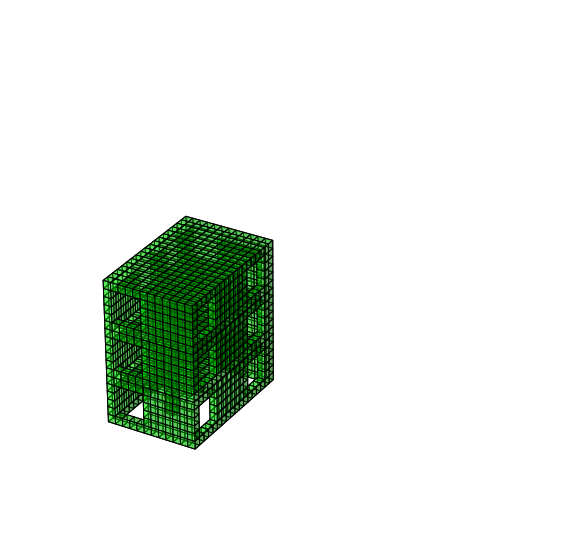

In [ ]:
x.ext_render_arch(input_0)

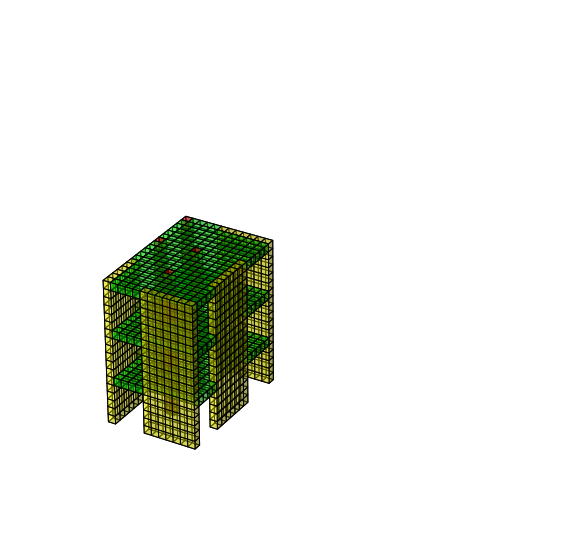

In [ ]:
x.ext_render_struct(label_0)

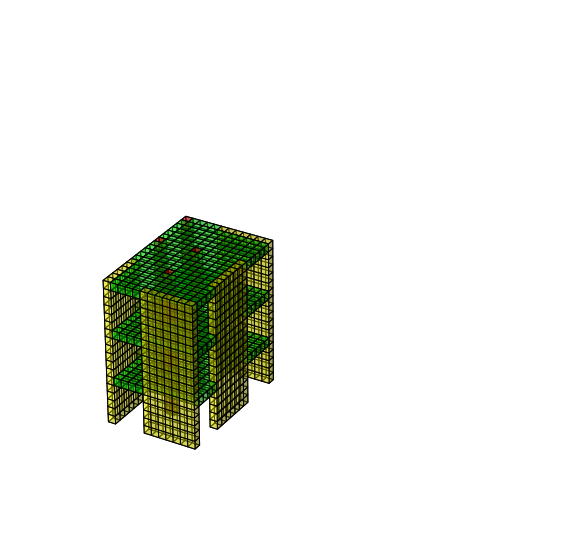

In [ ]:
x.ext_render_struct(pred)

In [ ]:
x.arch_input_plotly(input_0)

In [ ]:
x.struct_plotly(pred)